In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

TINY_SIZE = 14
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
#sns.set(style="darkgrid")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": BIGGER_SIZE,
    "axes.labelsize": MEDIUM_SIZE,
    "axes.titlesize": BIGGER_SIZE,
    "xtick.labelsize": TINY_SIZE, 
    "ytick.labelsize": TINY_SIZE, 
    "legend.fontsize": TINY_SIZE, 
    "figure.titlesize": BIGGER_SIZE, 
})

In [27]:
data_const_0 = pd.read_csv("../data_intro/ToySGD/constant/42/Ackley/aggregated_run_data.csv")
#data_const_1 = pd.read_csv("../data_intro/ToySGD/constant/42/Rastrigin/aggregated_run_data.csv")
data_const_1 = pd.read_csv("../data_intro/ToySGD/constant/43/Ackley/aggregated_run_data.csv")
data_const_2 = pd.read_csv("../data_intro/ToySGD/constant/44/Ackley/aggregated_run_data.csv")
data_sgdr_0 = pd.read_csv("../data_intro/ToySGD/sgdr/0/Ackley/aggregated_run_data.csv")

data_all = [data_const_0, data_const_1, data_const_2, data_sgdr_0]
labels = ["$\\alpha = 0.001$", "$\\alpha = 0.005$", "$\\alpha = 0.01$", "SGDR"]

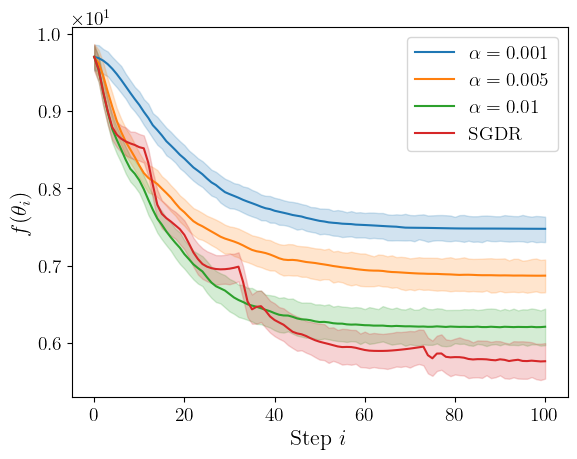

In [28]:
for data, label in zip(data_all, labels):
    ax = sns.lineplot(data,
                      x="batch",
                      y="f_cur",
                      label=label)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
#ax.set_yscale("log")
ax.set_xlabel("Step $i$")
ax.set_ylabel("$f(\\theta_i)$")
plt.savefig(Path("figures", "intro.pdf"), bbox_inches="tight")